# Time series forcasting with tensorflow + milestone project 3
This isnt financial advice

Lets write some tensorflow code to predict the price of bitcoin

# Factors affecting time series prediction problems
1. How well we understand the factors that contributes to it.
2. How much data is available
3. How much similar the future is to past
4. wether the forcast can affect the thing we are trying to forcast

In [1]:
## Get the data
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-12-07 03:28:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.004s  

2022-12-07 03:28:05 (43.0 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



We are going to use the historic data of bitcoin to try and predict the price of bitcoin in future

## Importing time series data

In [2]:
# Import using pandas
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates = ["Date"],
                 index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# How many samples do we have
len(df)

2787

We have collected the historical price of bitcoin for the last 8 years but the are only 2787 samples but a neural network model like milions of sample

**Note** The **Sesonality** of a time series dataset is reffered as the number of samples per year So for our Bitcoin data it has a sesonality of 365 as we collect one sample per day

In [5]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


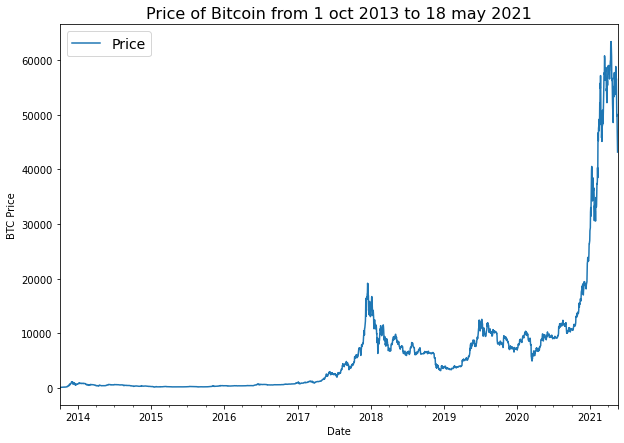

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 oct 2013 to 18 may 2021",fontsize=16)
plt.legend(fontsize=14);

In [7]:
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv","r") as f:
  csv_reader = csv.reader(f,delimiter=",")
  next(csv_reader) # Skips frist line (This gets rid of the columns title)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1],"%Y-%m-%d")) # Gets the date as dates not strings
    btc_price.append(float(line[2])) # get the closing price as float
# view the first 10 of each 
timesteps[:10],btc_price[:10]


([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

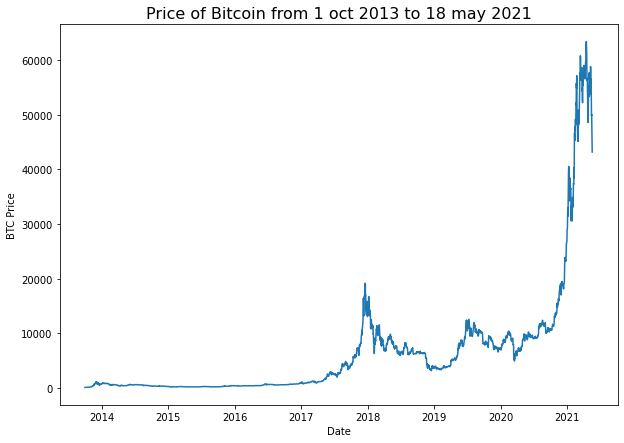

In [8]:
# Plot from csv
plt.figure(figsize=(10,7))
plt.plot(timesteps,btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 oct 2013 to 18 may 2021",fontsize=16)
plt.xlabel("Date")

## Format Data part 1 : Create training and test sets 

### The wrong way

In [9]:
# Get bitcoin data array 
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
timesteps[:10],prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [10]:
# Wrong way to make train test sets fpr time series

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(timesteps,
                                                 prices,
                                                 test_size=0.2,
                                                 random_state=42)

x_train.shape,x_test.shape,y_train.shape,y_train.shape

((2229,), (558,), (2229,), (2229,))

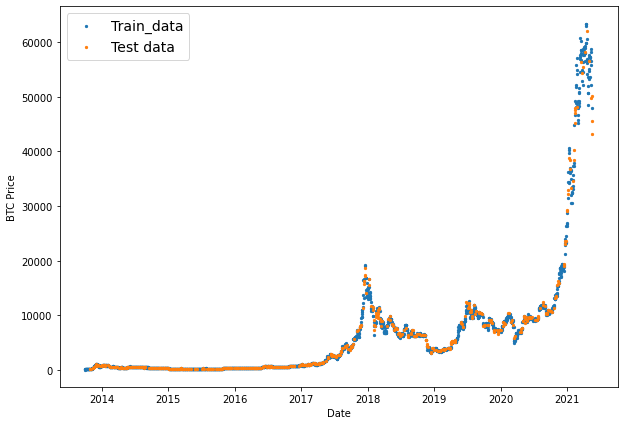

In [11]:
# Lets plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(x_train,y_train,s=5,label="Train_data")
plt.scatter(x_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

Notice the mixed dots 😆 Thats why its wrong  

##  Create the train and test sets the right way 

### Time series split

In [12]:
split_size = int(0.8*len(prices))
# Create train data splits
x_train,y_train = timesteps[:split_size],prices[:split_size]
# Create test data splits (everything beyond the split size )
x_test,y_test = timesteps[split_size:],prices[split_size:]
len(x_train),len(y_train),len(x_train),len(y_train)

(2229, 2229, 2229, 2229)

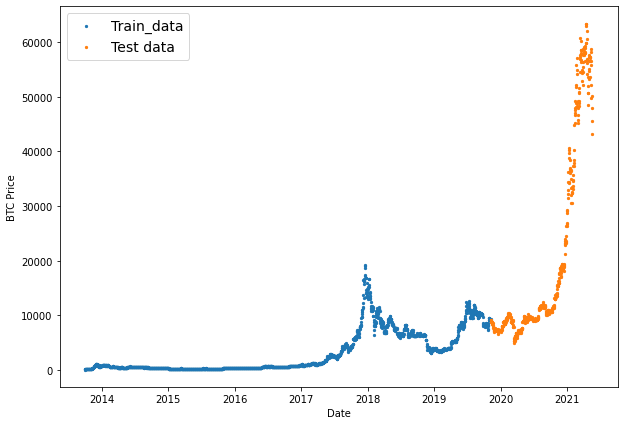

In [13]:
# Lets plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(x_train,y_train,s=5,label="Train_data")
plt.scatter(x_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

Now thats the right thing

## Create a ploting fuction

In [14]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

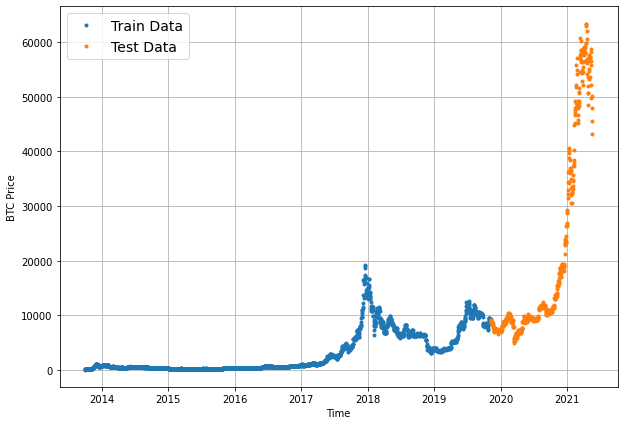

In [15]:
# Test out plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_train,values=y_train,label="Train Data")
plot_time_series(timesteps=x_test,values=y_test,label="Test Data")

## Modeling experiments
lets run a series of modelling experiments

# Lets build a naive model (model 0)
The formula is $$\hat{y}_{t} = y_{t-1}$$

The prediction at timestemp t is the same as previous

In [16]:
# Create a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10] ,naive_forecast[-10:]


(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [17]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

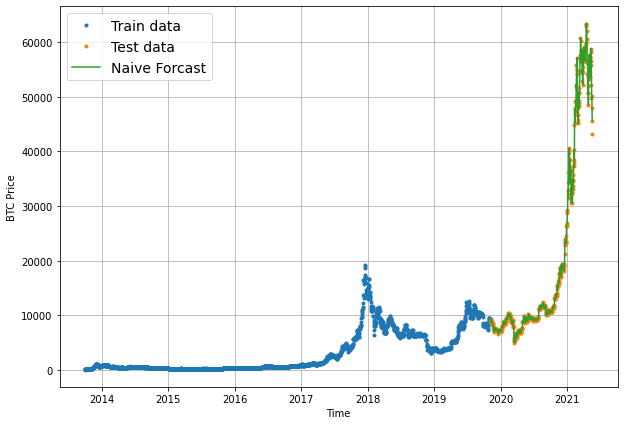

In [18]:
# Plot naive forcast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_train,values=y_train,label="Train data")
plot_time_series(timesteps=x_test,values=y_test,label="Test data")
plot_time_series(timesteps=x_test[1:],values=naive_forecast,format="-",label="Naive Forcast")

from numpy import number
## Evaluating a time series model

lets look at some evaluation metrics for time series forecasting

we are working on a regression model like thing we are predicting a number

so a few comman regression metrics are

* MAE
* MSE
* RMSE
* MASE
*sMASE

In [19]:
import tensorflow as tf

In [20]:
# Mase implementation
def mean_absolute_scaled_error(y_true,y_pred):
  """
  Implement MASE
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  return (mae/mae_naive_no_season)

In [21]:
mean_absolute_scaled_error(y_test[1:],naive_forecast)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182624>

In [22]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [23]:
naive_results = evaluate_preds(y_true=y_test[1:],y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [24]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [25]:
tf.reduce_min(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>

In [26]:
tf.reduce_max(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>

## Format Data part 2 : Windowing our data set 

why do we window ?

we window our time series dataset to turn our data into a supervised 
learning problem.


In [27]:
len(y_train)

2229

In [28]:
btc_price[:7] ,btc_price[7]

([123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795],
 123.033)

In [29]:
# lets setup global variables for window and horizon size 
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make the prediction

In [30]:
# Create function to label windowed data
def get_labelled_window(x,horizon=HORIZON):
  '''
  Create labels for windowed dataset
  
  E.g if horizon =1
  Input: [0,1,2,3,4,5,6,7] ------> Output: ([0,1,2,3,4,5,6] , [7])
  
  '''
  return (x[:,:-horizon],x[:,-horizon:])

In [31]:
# Test out the window labelling function
test_window, test_label = get_labelled_window (tf.expand_dims(tf.range(8)+1,axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

we need to do the above preprocessing on the complete time series

We can use numpy array indexing instead of for loops to speed things up

Let's write a function which:

* 1. Creates a window step of specific window size, for example: [[0, 1, 2, 3, 4, 5, 6, 7]]


* 2. Uses NumPy indexing to create a 2D of multiple window steps, for example:

        [[0, 1, 2, 3, 4, 5, 6, 7],
        
        [1, 2, 3, 4, 5, 6, 7, 8],
         [2, 3, 4, 5, 6, 7, 8, 9]]

* 3.Uses the 2D array of multuple window steps to index on a target series

* 4.Uses the get_labelled_windows() function we created above to turn the window steps into windows with a specified horizon

In [32]:
import numpy as np
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)

  return windows, labels

In [33]:
full_windows, full_labels = make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(2780, 2780)

In [34]:
# View the first 3
for i in range (3):
  print(f"Windsows:{full_windows[i]}--> Label {full_labels[i]}")

Windsows:[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]--> Label [123.033]
Windsows:[125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]--> Label [124.049]
Windsows:[108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ]--> Label [125.96116]


In [35]:
np.expand_dims(np.arange(len(prices)-(7+1-1)),axis=0).T

array([[   0],
       [   1],
       [   2],
       ...,
       [2777],
       [2778],
       [2779]])

In [36]:
np.expand_dims(np.arange(7+1),axis=0)

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [37]:
len(prices)

2787

In [38]:
f=tf.keras.preprocessing.timeseries_dataset_from_array(prices,sequence_length=7,targets=None ,batch_size=1)

In [39]:
for i in f:
  a=tf.squeeze(i)
  print(tf.squeeze(i))
  break

tf.Tensor([123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ], shape=(7,), dtype=float64)


In [40]:
get_labelled_window(np.expand_dims(a,axis=0))

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533]]),
 array([[121.795]]))

## Turning windows into training and test sets


In [41]:
# Make the train test splits
def make_train_test_split(windows,labels,test_split=0.2):
  """
  Split matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) # This will default to 80% train and 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return(train_windows,test_windows,train_labels,test_labels)

In [42]:
# Create train and test windows
train_windows,test_windows,train_labels,test_labels = make_train_test_split(full_windows,full_labels)
len(train_windows),len(test_windows),len(train_labels),len(test_labels)

(2224, 556, 2224, 556)

In [43]:
train_windows[:5],train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

## Make a Modeling check point

Because our model's performance will fluctuate from experiment to experiment we are going to write a model checkpoint so we can compare appels to appels.

More specifically we want to compare each of our models best performance against the other models best performance.

for example if our model performs the best on epoch 55 (but we are training for 100 epochs), we want to load and evaluate the model saved on epoch 55

We can create a modelling checkpoint callbacks by using tf keras callback model checkpoints

In [44]:
import os
# Create a function to implement the model callback checkpoint with a specific filename
def create_model_checkpoint(model_name,save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),
                                            verbos=0,
                                            save_best_only=True)



## Model 1: Dense model (window=7 horizon=1)

our first deep model is going to be simple dense model
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear or no activation
* Adam optimizer and MAE loss fuction
* Batch size of 128
* 100 epochs

Why these values ?

These were picked out through experimentations

**Hyperparameters** = values a machine learning practitioner can adjust themselves

**Parameters** = values a model learns on its own

In [45]:
import tensorflow as tf 
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)
# 1. Construct Model
model_1 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON, activation="linear") # Linear activation is just like having no activation at all
],name="model_1_dense")# name our model so we can save it
# 2. Compile
model_1.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])
# 3. Fit the model
model_1.fit(x = train_windows,
            y = train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 5s 106ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
Epoch 2/100
18/18 [==============================] - 1s 50ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1875 - val_loss: 1005.9993 - val_mae: 1005.9993 - val_mse: 3441833.2500
Epoch 3/100
18/18 [==============================] - 1s 61ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.6094 - val_loss: 923.2862 - val_mae: 923.2861 - val_mse: 2868220.7500
Epoch 4/100
18/18 [==============================] - 1s 65ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5781 - val_loss: 900.5872 - val_mae: 900.5872 - val_mse: 2683715.5000
Epoch 5/100
18/18 [==============================] - 1s 48ms/step - loss: 165.0894 - mae: 165.0894 - mse: 145490.7812 - val_loss: 895.2237 - val_mae: 895.2237 - val_mse: 2564574.5000
Epoch 6/100
18/18 [==============================] - 1s 75ms/step - loss: 158.

In [46]:
# Evaluate model on test data
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 585.9758 - mae: 585.9758 - mse: 1197802.1250


[585.9757690429688, 585.9757690429688, 1197802.125]

In [47]:
# Load in the best performing model
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.6250


[568.9510498046875, 568.9510498046875, 1171743.625]

## Making forcast with a model (on the test set)

It takes in a model  and does the following 
1. Takes some input data
2. Passes the data to the models predict method
3. Returns the predicted output

In [48]:
def make_preds(model,input_data):
  """
  Uses model to make predictions on input data
  """
  forcast = model.predict(input_data)
  return(tf.squeeze(forcast))

In [49]:
model_1_preds=make_preds(model_1,test_windows)
len(model_1_preds),model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.71 , 8769.887, 9015.711, 8795.519, 8723.811, 8730.111,
        8691.952, 8502.054, 8460.961, 8516.548], dtype=float32)>)

In [50]:
# Evaluate preds
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_1_preds)
model_1_results

{'mae': 568.9511,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.99948955}

In [51]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

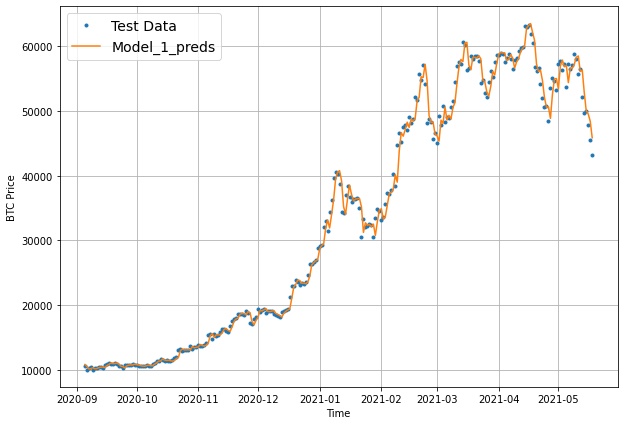

In [52]:
# Lets Plot our model 1 predictions
offset = 300

plt.figure(figsize=(10,7))

# Account for the test_window offset and index into test_labels to ensure correct plotting 
plot_time_series(timesteps = x_test[-len(test_windows):],values = test_labels[:,0],start=offset , label="Test Data")

plot_time_series(timesteps = x_test[-len(test_windows):],values =model_1_preds,start=offset,format = "-",label = "Model_1_preds")

In [53]:
input_data = prices[:-30]
targets = prices[30:]
Windows=tf.keras.preprocessing.timeseries_dataset_from_array(data=input_data,targets=targets,sequence_length=30,batch_size=None)

In [54]:
prices[:32]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
       126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
       152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
       180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ,
       196.02499, 198.04883])

In [55]:
windows = []
labels = []
for i,x in Windows:
    windows.append(i)
    labels.append(x)

In [56]:
windows[:10],labels[:10],len(windows),len(labels)

([<tf.Tensor: shape=(30,), dtype=float64, numpy=
  array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ])>,
  <tf.Tensor: shape=(30,), dtype=float64, numpy=
  array([125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499])>,
  <tf.Tensor: shape=(30,), dtype=float64, numpy=
  array([108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 12

In [57]:
len(windows),len(labels)

(2728, 2728)

In [58]:
2728*0.8

2182.4

In [59]:
train_windows = np.array(windows[:2183])
train_labels = np.array(labels[:2183])
test_windows = np.array(windows[2183:])
test_labels = np.array(labels[2183:])

In [60]:
train_windows[:3],test_windows[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [61]:
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2183, 2183, 545, 545)

## Creating Dense Model_2

In [62]:
import tensorflow as tf 
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)
# 1. Construct Model
model_2 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON, activation="linear") # Linear activation is just like having no activation at all
],name="model_2_dense")# name our model so we can save it
# 2. Compile
model_2.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])
# 3. Fit the model
model_2.fit(x = train_windows,
            y = train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
18/18 [==============================] - 1s 33ms/step - loss: 1045.5662 - mae: 1045.5662 - mse: 4253932.5000 - val_loss: 3442.8511 - val_mae: 3442.8511 - val_mse: 27193866.0000
Epoch 2/100
18/18 [==============================] - 0s 26ms/step - loss: 425.5170 - mae: 425.5170 - mse: 786516.3750 - val_loss: 1321.6090 - val_mae: 1321.6090 - val_mse: 4168320.2500
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 269.2410 - mae: 269.2410 - mse: 347976.1875 - val_loss: 1359.9800 - val_mae: 1359.9800 - val_mse: 5218970.0000
Epoch 4/100
18/18 [==============================] - 0s 28ms/step - loss: 216.6969 - mae: 216.6969 - mse: 216993.7500 - val_loss: 947.8182 - val_mae: 947.8182 - val_mse: 2766874.0000
Epoch 5/100
18/18 [==============================] - 0s 26ms/step - loss: 193.8449 - mae: 193.8449 - mse: 185441.9688 - val_loss: 883.8165 - val_mae: 883.8165 - val_mse: 2574323.7500
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 178

In [63]:
# Evaluate model_2 on test data
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 529.1037 - mae: 529.1037 - mse: 1027048.0625


[529.1036987304688, 529.1036987304688, 1027048.0625]

In [64]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 529.1037 - mae: 529.1037 - mse: 1027048.0625


[529.1036987304688, 529.1036987304688, 1027048.0625]

In [65]:
# Get the forcast predictions
model_2_preds = make_preds(model_2,input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [66]:
test_labels.shape

(545,)

In [67]:
model_2_results = evaluate_preds(y_true = tf.squeeze(test_labels),y_pred = model_2_preds)
model_2_results

{'mae': 529.1037,
 'mse': 1027047.94,
 'rmse': 1013.4337,
 'mape': 2.7406445,
 'mase': 1.0736358}

In [68]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

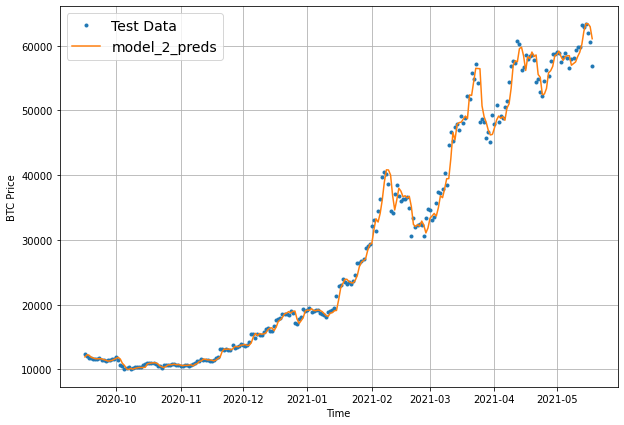

In [69]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset while ploting
plot_time_series(timesteps = x_test[-len(test_windows):], values = test_labels[:],start = offset, label ="Test Data")
plot_time_series(timesteps = x_test[-len(test_windows):], values=model_2_preds, start=offset, format="-",label="model_2_preds")

## Creating model 3

In [70]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE,horizon = HORIZON)
len(full_windows),len(full_labels)

(2751, 2751)

In [71]:
train_windows , test_windows , train_labels , test_labels = make_train_test_split(windows = full_windows, labels=full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2200, 2200, 551, 551)

In [72]:
# This model contains window size of 30 and horizon of 7
import tensorflow as tf 
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)
# 1. Construct Model
model_3 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON, activation="linear") # Linear activation is just like having no activation at all
],name="model_3_dense")# name our model so we can save it
# 2. Compile
model_3.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])
# 3. Fit the model
model_3.fit(x = train_windows,
            y = train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
18/18 [==============================] - 1s 34ms/step - loss: 1476.6752 - mae: 1476.6752 - mse: 10390733.0000 - val_loss: 3088.5613 - val_mae: 3088.5613 - val_mse: 24386346.0000
Epoch 2/100
18/18 [==============================] - 0s 26ms/step - loss: 552.8943 - mae: 552.8943 - mse: 1336176.8750 - val_loss: 2462.4548 - val_mae: 2462.4548 - val_mse: 17112268.0000
Epoch 3/100
18/18 [==============================] - 0s 28ms/step - loss: 435.1978 - mae: 435.1978 - mse: 893449.0000 - val_loss: 2283.1484 - val_mae: 2283.1484 - val_mse: 14950889.0000
Epoch 4/100
18/18 [==============================] - 0s 26ms/step - loss: 391.9787 - mae: 391.9787 - mse: 745983.8125 - val_loss: 1975.1218 - val_mae: 1975.1218 - val_mse: 11680637.0000
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 357.9485 - mae: 357.9485 - mse: 627137.9375 - val_loss: 2000.1556 - val_mae: 2000.1556 - val_mse: 11665231.0000
Epoch 6/100
18/18 [==============================] - 0s 26ms/step 

In [73]:
# Evaluate the model on the test data

model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1300.1522 - mae: 1300.1522 - mse: 5599956.0000


[1300.1522216796875, 1300.1522216796875, 5599956.0]

In [74]:
# Load best model
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5065 - mae: 1237.5065 - mse: 5405199.0000


[1237.5064697265625, 1237.5064697265625, 5405199.0]

In [75]:
# Make predictions with model_3
model_3_preds = make_preds(model_3,
                           input_data = test_windows)
model_3_preds[:5] 


18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
        9357.3545],
       [8735.506 , 8840.303 , 9247.793 , 8885.601 , 9097.186 , 9174.327 ,
        9156.818 ],
       [8672.508 , 8782.387 , 9123.857 , 8770.371 , 9007.13  , 9003.869 ,
        9042.725 ],
       [8874.399 , 8784.74  , 9043.902 , 8943.052 , 9033.477 , 9176.489 ,
        9039.677 ],
       [8825.891 , 8777.44  , 8926.78  , 8870.179 , 9213.232 , 9268.156 ,
        8942.487 ]], dtype=float32)>

In [76]:
# Evaluate model 3 results 
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred = model_3_preds)
model_3_results

{'mae': array([ 513.6056  ,  355.08328 ,  327.17075 ,  358.5106  ,  420.53305 ,
         537.854   ,  545.66156 ,  485.9228  ,  584.49713 ,  687.3824  ,
         836.2264  ,  755.1577  ,  731.4958  ,  775.3399  ,  567.95544 ,
         266.80865 ,  188.80225 ,  188.10799 ,  253.095   ,  301.43256 ,
         151.10721 ,  196.81473 ,  191.46178 ,  231.65031 ,  143.61125 ,
         122.59089 ,  132.78879 ,  190.8118  ,  179.15994 ,  228.26018 ,
         314.44022 ,  379.09244 ,  278.32526 ,  295.3471  ,  299.3852  ,
         248.64983 ,  299.75662 ,  259.69434 ,  180.30531 ,  206.72922 ,
         374.62863 ,  144.85086 ,  142.33635 ,  131.11613 ,   93.941124,
          54.825542,   73.79541 ,  103.60128 ,  121.333916,  168.67278 ,
         183.90945 ,  152.25307 ,  186.57191 ,  146.91267 ,  240.42912 ,
         351.00662 ,  540.952   ,  549.1573  ,  521.2411  ,  526.8554  ,
         453.36237 ,  257.98117 ,  277.29486 ,  301.8247  ,  455.718   ,
         458.96017 ,  503.4438  ,  522.3119 

In [77]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([551, 7]), TensorShape([545]))

In [78]:
## Make our evaluation function work for large horizons

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}
     

In [79]:
# Get model 3 values agregated
model_3_results = evaluate_preds(y_true = tf.squeeze(test_labels),y_pred = model_3_preds)
model_3_results

{'mae': 1237.5065,
 'mse': 5405199.0,
 'rmse': 1425.7478,
 'mape': 5.558879,
 'mase': 2.2020733}

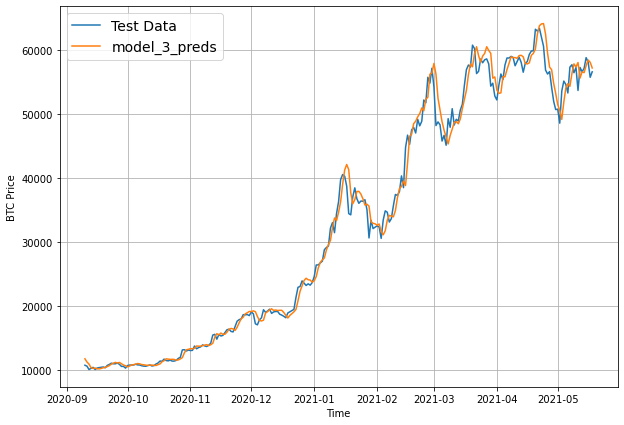

In [80]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset while ploting
plot_time_series(timesteps = x_test[-len(test_windows):], values = test_labels[:,0],start = offset,format="-", label ="Test Data")
plot_time_series(timesteps = x_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds,axis = 1), start=offset, format="-",label="model_3_preds")

## Which of our model is performing better so far




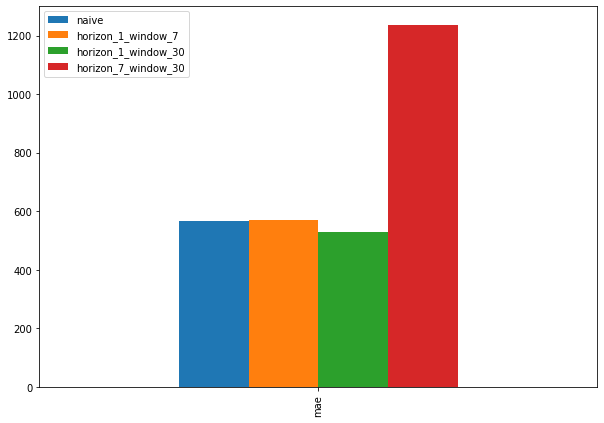

In [81]:
pd.DataFrame({"naive": naive_results["mae"],
             "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30":model_2_results["mae"],
             "horizon_7_window_30": model_3_results["mae"]},index=["mae"]).plot(figsize=(10,7),kind="bar");

## Making model 4 CONVD

In [82]:
HORIZON = 1
WINDOW_SIZE = 7

In [83]:
# Create window data
full_windows,full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows),len(full_labels)

(2780, 2780)

In [84]:
# Create train/test sets
train_windows,test_windows,train_labels,test_labels = make_train_test_split(full_windows,full_labels)


In [85]:
len(train_windows),len(train_labels), len(test_windows),len(test_labels)

(2224, 2224, 556, 556)

To use the conv1D layer, We need an input shape of : '(batch_size,timesteps,input_dim)'...
However our data isnt in that shape yet

In [86]:
# Check data input shape
train_windows[0].shape

(7,)

In [87]:
# Before we pass our data to the con1D Layer we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [88]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x,axis=1)) # add extra dimenssion for the input dim


In [89]:
# Test out our lambda layer 
print(f"Orignal shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Orignal values with expanded shape: \n{expand_dims_layer(x)}")

Orignal shape: (7,)
Expanded shape: (7, 1)
Orignal values with expanded shape: 
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [90]:
# Create a con1D model
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,axis=1)),
    layers.Conv1D(filters = 128,kernel_size =5 , strides = 1, padding="causal",activation = "relu"),
    layers.Dense(HORIZON)
],name ="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam())
#Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose = 1,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name = model_4.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 1227.0372  

18/18 [==============================] - 7s 52ms/step - loss: 1207.3817 - val_loss: 2320.6218
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 316.2171

18/18 [==============================] - 1s 63ms/step - loss: 316.2171 - val_loss: 1467.2799
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 192.6853

18/18 [==============================] - 1s 57ms/step - loss: 192.6853 - val_loss: 1164.7074
Epoch 4/100
 9/18 [==============>...............] - ETA: 0s - loss: 197.5116

18/18 [==============================] - 1s 47ms/step - loss: 177.3535 - val_loss: 981.6695
Epoch 5/100
13/18 [====================>.........] - ETA: 0s - loss: 178.2423

18/18 [==============================] - 1s 55ms/step - loss: 172.3467 - val_loss: 960.8708
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 130.1246

18/18 [==============================] - 1s 35ms/step - loss: 171.9753 - val_loss: 950.2026
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 209.6378

18/18 [==============================] - 1s 35ms/step - loss: 167.1943 - val_loss: 943.2872
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 143.1056

18/18 [==============================] - 1s 35ms/step - loss: 163.5990 - val_loss: 905.5262
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 162.5455 - val_loss: 929.7607
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 176.2612

18/18 [==============================] - 1s 36ms/step - loss: 158.5780 - val_loss: 871.9778
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 172.6847

18/18 [==============================] - 1s 36ms/step - loss: 154.0058 - val_loss: 852.7120
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 151.2620 - val_loss: 944.1970
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 150.2688 - val_loss: 881.1826
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 157.3245

18/18 [==============================] - 1s 50ms/step - loss: 145.4593 - val_loss: 849.1818
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 143.7761

18/18 [==============================] - 1s 37ms/step - loss: 143.3640 - val_loss: 844.4007
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 131.3044

18/18 [==============================] - 1s 36ms/step - loss: 139.8764 - val_loss: 806.7261
Epoch 17/100
18/18 [==============================] - 0s 4ms/step - loss: 138.1677 - val_loss: 812.6340
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 147.8408

18/18 [==============================] - 1s 36ms/step - loss: 137.9497 - val_loss: 775.2100
Epoch 19/100
16/18 [=========================>....] - ETA: 0s - loss: 131.4018

18/18 [==============================] - 1s 37ms/step - loss: 131.1450 - val_loss: 755.4260
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 138.0260

18/18 [==============================] - 1s 36ms/step - loss: 132.4057 - val_loss: 712.2014
Epoch 21/100
16/18 [=========================>....] - ETA: 0s - loss: 130.2775

18/18 [==============================] - 1s 37ms/step - loss: 131.0829 - val_loss: 707.4122
Epoch 22/100
16/18 [=========================>....] - ETA: 0s - loss: 128.3458

18/18 [==============================] - 1s 37ms/step - loss: 126.9511 - val_loss: 692.9736
Epoch 23/100
17/18 [===========================>..] - ETA: 0s - loss: 124.0546

18/18 [==============================] - 1s 38ms/step - loss: 125.1489 - val_loss: 682.4753
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 133.3014

18/18 [==============================] - 1s 56ms/step - loss: 124.3786 - val_loss: 670.8320
Epoch 25/100
11/18 [=================>............] - ETA: 0s - loss: 127.7486

18/18 [==============================] - 1s 71ms/step - loss: 121.6896 - val_loss: 662.6083
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 123.1287

18/18 [==============================] - 1s 80ms/step - loss: 121.5705 - val_loss: 654.6090
Epoch 27/100
11/18 [=================>............] - ETA: 0s - loss: 129.3547

18/18 [==============================] - 2s 100ms/step - loss: 122.6445 - val_loss: 650.9058
Epoch 28/100
10/18 [===============>..............] - ETA: 0s - loss: 121.7312

18/18 [==============================] - 1s 81ms/step - loss: 117.9562 - val_loss: 645.4808
Epoch 29/100
11/18 [=================>............] - ETA: 0s - loss: 118.6137

18/18 [==============================] - 1s 85ms/step - loss: 117.1769 - val_loss: 639.9748
Epoch 30/100
10/18 [===============>..............] - ETA: 0s - loss: 113.3276

18/18 [==============================] - 1s 80ms/step - loss: 121.0468 - val_loss: 630.7950
Epoch 31/100
18/18 [==============================] - 0s 12ms/step - loss: 114.9061 - val_loss: 652.6464
Epoch 32/100
10/18 [===============>..............] - ETA: 0s - loss: 120.8926

18/18 [==============================] - 1s 88ms/step - loss: 116.4313 - val_loss: 623.4980
Epoch 33/100
18/18 [==============================] - 0s 11ms/step - loss: 115.7972 - val_loss: 664.3209
Epoch 34/100
11/18 [=================>............] - ETA: 0s - loss: 122.2740

18/18 [==============================] - 1s 79ms/step - loss: 117.2043 - val_loss: 613.7654
Epoch 35/100
18/18 [==============================] - 0s 9ms/step - loss: 113.4074 - val_loss: 619.6227
Epoch 36/100
10/18 [===============>..............] - ETA: 0s - loss: 111.0761

18/18 [==============================] - 1s 57ms/step - loss: 116.8330 - val_loss: 605.7616
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 134.0515

18/18 [==============================] - 1s 73ms/step - loss: 114.7925 - val_loss: 603.6094
Epoch 38/100
17/18 [===========================>..] - ETA: 0s - loss: 113.5004

18/18 [==============================] - 1s 85ms/step - loss: 113.0861 - val_loss: 602.5891
Epoch 39/100
10/18 [===============>..............] - ETA: 0s - loss: 115.8286

18/18 [==============================] - 2s 91ms/step - loss: 111.9831 - val_loss: 602.2945
Epoch 40/100
16/18 [=========================>....] - ETA: 0s - loss: 111.4864

18/18 [==============================] - 1s 47ms/step - loss: 111.2691 - val_loss: 600.5515
Epoch 41/100
18/18 [==============================] - 0s 4ms/step - loss: 112.0727 - val_loss: 623.0615
Epoch 42/100
18/18 [==============================] - 0s 4ms/step - loss: 116.7095 - val_loss: 645.0155
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 118.9676 - val_loss: 659.5667
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 125.4497 - val_loss: 678.8228
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 115.4361 - val_loss: 611.8370
Epoch 46/100
18/18 [==============================] - ETA: 0s - loss: 114.1717

18/18 [==============================] - 1s 36ms/step - loss: 114.1717 - val_loss: 589.6738
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 113.7248 - val_loss: 720.2481
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 112.0136 - val_loss: 597.4332
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 110.5680 - val_loss: 665.2030
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 119.7653 - val_loss: 635.1696
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 97.6753

18/18 [==============================] - 1s 37ms/step - loss: 110.7739 - val_loss: 586.0245
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 111.2179 - val_loss: 595.2483
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 113.6466 - val_loss: 670.5778
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 126.7883 - val_loss: 648.2971
Epoch 55/100
18/18 [==============================] - 0s 4ms/step - loss: 110.6968 - val_loss: 593.8555
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 109.8592 - val_loss: 766.5007
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 124.8183 - val_loss: 712.2674
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 120.3515 - val_loss: 698.5149
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 110.8185 - val_loss: 592.1150
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 11

18/18 [==============================] - 1s 53ms/step - loss: 108.1684 - val_loss: 577.6281
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 108.7932 - val_loss: 610.1495
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 110.4675 - val_loss: 652.9427
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 110.7312 - val_loss: 583.0664
Epoch 66/100
18/18 [==============================] - 0s 4ms/step - loss: 108.3487 - val_loss: 587.8362
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 108.0646 - val_loss: 648.5150
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 113.6957 - val_loss: 675.1595
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 124.3082 - val_loss: 632.9845
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 124.3231 - val_loss: 588.5080
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 11

18/18 [==============================] - 1s 37ms/step - loss: 106.6291 - val_loss: 575.4403
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 192.2652

18/18 [==============================] - 1s 35ms/step - loss: 114.2934 - val_loss: 571.6199
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 111.1759 - val_loss: 666.0590
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 112.2543 - val_loss: 580.0314
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 107.7741 - val_loss: 599.6221
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 108.7533 - val_loss: 599.0880
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 106.9682 - val_loss: 596.5336
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 107.9607 - val_loss: 598.1052
Epoch 89/100
 1/18 [>.............................] - ETA: 0s - loss: 106.7720

18/18 [==============================] - 1s 36ms/step - loss: 107.3045 - val_loss: 570.8284
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 108.0094 - val_loss: 642.3939
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 113.7574 - val_loss: 625.3716
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 108.0017 - val_loss: 627.3054
Epoch 93/100
18/18 [==============================] - 0s 4ms/step - loss: 118.0999 - val_loss: 637.1274
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 111.3195 - val_loss: 579.6985
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 106.8561 - val_loss: 572.8486
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 115.0598 - val_loss: 602.3210
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 109.4901 - val_loss: 616.3585
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 11

In [91]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [92]:
# Evaluate model
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 610.1541


610.154052734375

In [93]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 570.8284


570.828369140625

In [94]:
# Make predictions first
model_4_preds = make_preds(model_4,test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8851.464, 8754.47 , 8983.927, 8759.671, 8703.627, 8708.294,
       8661.667, 8494.839, 8435.316, 8492.114], dtype=float32)>

In [95]:
# Evalute preds
model_4_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_4_preds)
model_4_results

{'mae': 570.82837,
 'mse': 1176671.2,
 'rmse': 1084.7448,
 'mape': 2.5593357,
 'mase': 1.0027874}

In [96]:
model_1_results

{'mae': 568.9511,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.99948955}

## Model_5: RNN(LSTM)

In [97]:

tf.random.set_seed(42)

# Lets build an LSTM model with the functional api
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs)
#x = layers.LSTM(128,return_sequences=True)(x)
x = layers.LSTM(128,activation="relu")(x)
#x = layers.Dense(32,activation = "relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs,outputs=output,name="model_5_LSTM")

# Compile
model_5.compile(loss = "mae",
                 optimizer = tf.keras.optimizers.Adam())

# Fit 
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose = 1,
            batch_size =128,
            validation_data =(test_windows,test_labels),
            callbacks = [create_model_checkpoint(model_name = model_5.name)])

Epoch 1/100
18/18 [==============================] - 3s 112ms/step - loss: 2323.6082 - val_loss: 9222.6523
Epoch 2/100
18/18 [==============================] - 2s 114ms/step - loss: 695.4739 - val_loss: 1486.0555
Epoch 3/100
18/18 [==============================] - 2s 97ms/step - loss: 237.3967 - val_loss: 1298.9084
Epoch 4/100
18/18 [==============================] - 2s 98ms/step - loss: 181.9180 - val_loss: 966.6431
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 173.4022 - val_loss: 970.9295
Epoch 6/100
18/18 [==============================] - 2s 96ms/step - loss: 173.5414 - val_loss: 941.4746
Epoch 7/100
18/18 [==============================] - 2s 118ms/step - loss: 170.3566 - val_loss: 898.5215
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 157.6712 - val_loss: 914.8642
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 166.5143 - val_loss: 1079.0776
Epoch 10/100
18/18 [==============================] - 2s 9

In [98]:
# Load in best version of model 5 and evaluate it
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 594.6030


594.6029663085938

In [99]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5,test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8978.46 , 8810.951, 8997.779, 8836.308, 8731.047], dtype=float32)>

In [100]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_5_preds)
model_5_results

{'mae': 594.60297,
 'mse': 1267231.9,
 'rmse': 1125.7139,
 'mape': 2.6717565,
 'mase': 1.0445527}

## Make a multivariate time series dataset

Before we add a feature to our time series what is the feature we can use

one feature we could add is wether or not *** tweeted that day

Whats better feature is there to use
how about the bitcoin halving event

In [101]:
# Lets make a multivariate time series
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


In [102]:
# Lets add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 january 2009 - this block reward isnt in our dataset
block_reward_2 = 25 # 8 nov 2012
block_reward_3 = 12.5 # 9 july 2006
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [103]:
# Create date ranges of where specific block_reward values will be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days,block_reward_3_days

(1012, 2421)

In [104]:
# Add in block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days,-1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:,-1] = block_reward_4

In [105]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [106]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


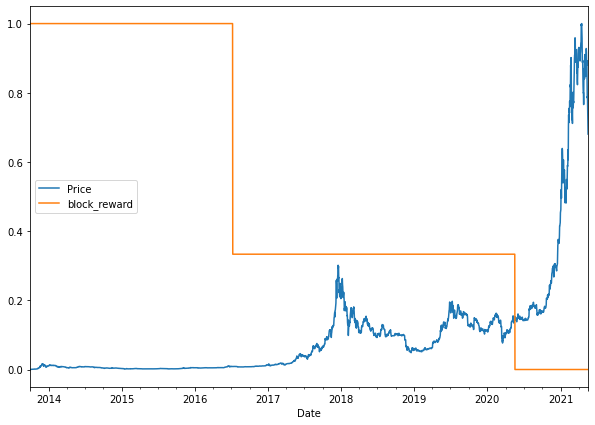

In [107]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price","block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index = bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7))

## Making a windowed dataset with pandas
Previously we turned our univariate time series into windows but this time we got multivariate time series so we will use pandas.DataFrame.shift

In [108]:
# Setup dataset hyperparameters
HORIZON =1
WINDOW_SIZE = 7

In [109]:
# Make a copy of the bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift value for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we have done is created a way to window our dataset directly from the dataset

[0,1,2,3,4,5,6,block_reward] -> [7]

[1,2,3,4,5,6,7,block_reward] -> [8]

[2,3,4,5,6,7,8,block_reward] -> [9]

In [110]:
x = bitcoin_prices_windowed.dropna().drop("Price",axis =1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
x.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [111]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [112]:
# Make train test sets using indexing
split_size = int(len(x)*0.8)
x_train, y_train = x[:split_size],y[:split_size]
x_test, y_test = x[split_size:] , y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6 : Dense (multivariate)

In [113]:
import tensorflow as tf 
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)
# 1. Construct Model
model_6 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON) # Linear activation is just like having no activation at all
],name="model_6_dense")# name our model so we can save it
# 2. Compile
model_6.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])
# 3. Fit the model
model_6.fit(x_train,
            y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(x_test,y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
18/18 [==============================] - 1s 34ms/step - loss: 1234.6804 - mae: 1234.6804 - mse: 5282005.5000 - val_loss: 2061.9077 - val_mae: 2061.9077 - val_mse: 11377605.0000
Epoch 2/100
18/18 [==============================] - 0s 26ms/step - loss: 351.5053 - mae: 351.5053 - mse: 499358.0312 - val_loss: 1908.6733 - val_mae: 1908.6733 - val_mse: 8719443.0000
Epoch 3/100
18/18 [==============================] - 0s 26ms/step - loss: 235.4153 - mae: 235.4153 - mse: 276006.8125 - val_loss: 1329.0585 - val_mae: 1329.0585 - val_mse: 4991872.0000
Epoch 4/100
18/18 [==============================] - 0s 25ms/step - loss: 208.6112 - mae: 208.6112 - mse: 219502.7188 - val_loss: 1102.1342 - val_mae: 1102.1342 - val_mse: 3934655.5000
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 196.5770 - mae: 196.5770 - mse: 204309.3750 - val_loss: 1107.8474 - val_mae: 1107.8474 - val_mse: 3822059.0000
Epoch 6/100
18/18 [==============================] - 0s 26ms/step - loss

In [114]:
# Evaluate multivariate model
model_6.evaluate(x_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 626.7440 - mae: 626.7440 - mse: 1282530.1250


[626.7440185546875, 626.7440185546875, 1282530.125]

In [115]:
# Load best model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense")
model_6.evaluate(x_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.8899 - mae: 567.8899 - mse: 1164816.5000


[567.889892578125, 567.889892578125, 1164816.5]

In [116]:
# Make predictions on the test data
model_6_preds = tf.squeeze(model_6.predict(x_test))
model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8844.684, 8769.905, 9045.17 , 8747.686, 8728.429, 8772.757,
       8667.292, 8503.437, 8470.313, 8527.244], dtype=float32)>

In [117]:
model_6_results = evaluate_preds(y_true = y_test,
                                 y_pred = model_6_preds)
model_6_results

{'mae': 567.8899,
 'mse': 1164816.4,
 'rmse': 1079.2666,
 'mape': 2.5460758,
 'mase': 0.99762523}

In [118]:
model_1_results

{'mae': 568.9511,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.99948955}

In [119]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

multi input model hmm how can we do that

## Model 7 NBEATS ALGORITHM
The most biggest time series forcasting algorithm so far
https://arxiv.org/pdf/1905.10437.pdf

* This will allow us to practice replicating a paper with tensorflow code
* We will see how to use Tensorflow layer subclassing (to make our own custom layers
*Get experience using the FUnctional API to create a custom architecture
* Potentially get state of the art results on our model

## Building and testing the N-BEATS block layer
Because the N-BEATS block layer doesnt exist in tensorflow we have got to create it.
To create custom layers and models in Tensorflow we can use subclassing:
https://www.tensorflow.org/guide/keras/custom_layers_and models

In [124]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

lets test our nbeats block class

In [125]:
# Set up a dummy nbeats layer to represent the inputs and out puts
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size = WINDOW_SIZE + HORIZON,
                                       horizon = HORIZON,
                                       n_neurons = 128,
                                       n_layers = 4)

In [126]:
# Create Dummy inputs (have to be same size as input size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1,axis=0)# input shape to the model has to reflect dense layer input requiremnets
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [128]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.4683625  -0.62728995  0.2366477   0.32464933 -0.23003682 -0.91415673
  0.30542657]
Forecast: 0.23829059302806854


## Preparing data for thw nbeats algorithm using tf data

In [129]:
HORIZON =1
WINDOW_SIZE = 7

In [130]:
# Create nbeats data input 
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [131]:
# Add Windowed Columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}]"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()


,Price,Price+1],Price+2],Price+3],Price+4],Price+5],Price+6],Price+7]
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [132]:
# Make features and labels
x = bitcoin_prices_nbeats.dropna().drop("Price",axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(x)*0.8)
x_train,y_train = x[:split_size],y[:split_size]
x_test,y_test = x[split_size:],y[split_size:]
len(x_train),len(y_train),len(x_test),len(y_test)

(2224, 2224, 556, 556)

In [133]:
# Time to make our data set performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping them
train_dataset = tf.data.Dataset.zip((train_features_dataset,test_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset,test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset,test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperprameters for N-BEATS algorithm
The N-BEATS algorithm has a fair few number of parameters, many of them can be found in tabel 18: https://arxiv.org/pdf.1905.10437.pdf

In [134]:
# Values from N-BEATS Paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE*HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE,THETA_SIZE

(7, 8)

In [ ]:
### Getting ready for residual stacking